# Mini-Project 1

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

Gtk-Message: 12:28:20.728: Failed to load module "canberra-gtk-module"


## Usefull functions

In [2]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:

        
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

In [3]:
###############
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
loadFSL()
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

12:28:30: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:28:30: Debug: Adding duplicate animation handler for '1' type
12:28:30: Debug: Adding duplicate animation handler for '2' type
12:28:30: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:28:30: Debug: Adding duplicate animation handler for '1' type
12:28:30: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:4672): Gtk-CRITICAL **: 12:28:30.737: gtk_window_resize: assertion 'height > 0' failed


# Visualization of the data in FSL

Take care of the path of the file! 

In [6]:
fsleyesDisplay.load(op.expandvars('/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/T1w/T1w'))

In [7]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/fMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR'))


(ipykernel_launcher.py:2992): Gdk-WARNING **: 14:36:20.110: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/fMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL'))

# Use BIDS standard

In [4]:
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subject_dir = 'sub-{}'.format(subject)

anat_dir = op.join(bids_root,subject_dir,"anat")
func_dir = op.join(bids_root,subject_dir,"func")

#### TO RUN ONLY IF YOU DON'T HAVE THE STRUCTURE

In [6]:
mkdir_no_exist(bids_root)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap'))

In [7]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- sub-101410_task-motorLR_bold.nii
|--------- sub-101410_task-motorLR_events.tsv
|--------- sub-101410_task-motorRL_bold.nii
|--------- sub-101410_task-motorRL_events.tsv


#### Now, we have to place the files we have downloaded before in the good directories according to the BIDS standard
#### TO RUN ONLY IF YOU DON'T HAVE THE STRUCTURE

In [8]:
import shutil

# Create the anat and func folders
os.makedirs(anat_dir, exist_ok=True)
os.makedirs(func_dir, exist_ok=True)

anat_src = op.join(bids_root, "T1w", "T1w.nii.gz")
func_root = op.join(bids_root, "fMRI")

# Déplacer et renommer le T1w
anat_dest = op.join(anat_dir, f"sub-{subject}_T1w.nii.gz")
shutil.copy(anat_src, anat_dest)

# Gérer les deux runs fMRI (LR et RL)
fmri_tasks = {
    "tfMRI_MOTOR_LR": "motorLR",
    "tfMRI_MOTOR_RL": "motorRL"
}

for folder, task_name in fmri_tasks.items():
    func_path = op.join(func_root, folder)
    bold_src = op.join(func_path, f"{folder}.nii")
    events_src = op.join(func_path, f"events_{folder.split('_')[-1]}.csv")

    bold_dest = op.join(func_dir, f"sub-{subject}_task-{task_name}_bold.nii")
    events_dest = op.join(func_dir, f"sub-{subject}_task-{task_name}_events.tsv")

    shutil.copy(bold_src, bold_dest)
    shutil.copy(events_src, events_dest)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/T1w/T1w.nii.gz'

In [9]:
print_dir_tree(bids_root, max_depth=4)

|subject101410/
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- sub-101410_task-motorLR_bold.nii
|--------- sub-101410_task-motorLR_events.tsv
|--------- sub-101410_task-motorRL_bold.nii
|--------- sub-101410_task-motorRL_events.tsv


#### Nice! All the files are at the right place with the right name (we don't need the T1w and fMRI folders anymore)

# 1. Structural preprocessing

## Skull-Stripping

In [5]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "101410", robust = True)  # To improve the fit

Done with BET.


In [6]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(anat_dir,"sub-101410_T1w"))
fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:453): Gdk-WARNING **: 10:01:42.827: gdkdrawable-x11.c:952 drawable is not a pixmap or window


#### Look how good the mask fits the brain. Do manual correction in FSL if needed (see Lab 2)

### Applying the mask

In [7]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    ###########################
    # Solution
    # By reading fslmaths documentation, one can see that the -mas option is exactly what we desire.
    ###########################
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask.nii.gz') # The mask to use

########################
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [8]:
#fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

## Segmentation

Takes a long time to run

In [9]:
anatomical_path = op.join(bids_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w')

#########################
# We must apply FAST to the brain-extracted image. Thus we must use the BET path brain.
##########################
fast_target = bet_path 

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [13]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- sub-101410_task-motorLR_bold.nii
|--------- sub-101410_task-motorLR_events.tsv
|--------- sub-101410_task-motorRL_bold.nii
|--------- sub-101410_task-motorRL_events.tsv


The pve files correspond to our segmented tissues. We have exactly three files, because we set n_classes to 3 above:
```python
fast(..., n_classes=3)
```

Let's try to identify which segmentation is which tissue type in the brain. To do this, you'll have to visualize the tissues and decide for yourself.

To make it easier on you, we will display:

- pve_0 in <span style="color:red;">red</span> --> cerebrospinal fluid
- pve_1 in <span style="color:green;">green</span> --> grey matter
- pve_2 in <span style="color:blue;">blue</span> --> white matter

In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

# 2. Functional preprocessing

In [14]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(func_dir,"sub-101410_task-motorLR_bold"))


(ipykernel_launcher.py:493): Gdk-WARNING **: 20:36:48.711: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## Concatenating

Plot of the mean voxel intensities for each run

[Text(0.5, 0, 'Time (volume)'), Text(0, 0.5, 'Mean voxel intensity')]

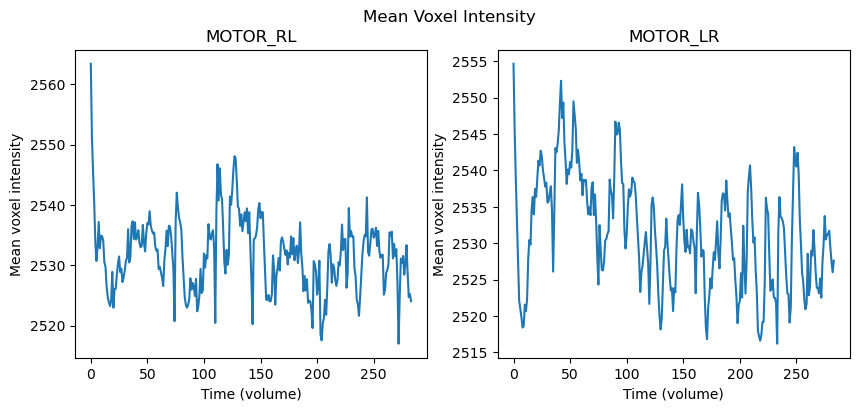

In [11]:
import matplotlib.pyplot as plt
import nibabel as nib
import os.path as op

mean_LR = nib.load(op.join(bids_root, 'sub-101410', 'func', 'sub-101410_task-motorLR_bold.nii')).get_fdata().mean(axis=(0,1,2))
mean_RL = nib.load(op.join(bids_root, 'sub-101410', 'func', 'sub-101410_task-motorRL_bold.nii')).get_fdata().mean(axis=(0,1,2))


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Mean Voxel Intensity')

ax1.plot(mean_RL)
ax1.set_title('MOTOR_RL')
ax1.set(xlabel='Time (volume)', ylabel='Mean voxel intensity')

ax2.plot(mean_LR)
ax2.set_title('MOTOR_LR')
ax2.set(xlabel='Time (volume)', ylabel='Mean voxel intensity')

Because the first couple of volumes have an above average intensity, we will trim the number of volumes, i.e. remove the first two volumes of each run.

In [12]:
n_scan_run = nib.load(op.join(bids_root, 'sub-101410', 'func', 'sub-101410_task-motorLR_bold.nii')).shape[3]
n_scan_run

284

In [13]:
file_to_trim = glob.glob(op.join(bids_root, 'sub-101410', 'func', 'sub-101410_task-motorLR_bold.nii'))[0]
output_target = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motorLR_bold_settled.nii.gz')

# For this, knowing that there are originally 184 volumes and that you want to throw away the first 10, please fill in
# the following variables
start_vol = 2 # Where should we start? (First volume is 0, not 1 !)
number_of_volumes = n_scan_run - start_vol # How many volumes should we keep?   

# Function creating new nifti with trimmed number of volumes
fslroi(file_to_trim, output_target, str(start_vol), str(number_of_volumes))
print(f"You kept {nib.load(output_target).shape[-1]} volumes.")

You kept 282 volumes.


In [14]:
file_to_trim = glob.glob(op.join(bids_root, 'sub-101410', 'func', 'sub-101410_task-motorRL_bold.nii'))[0]
output_target = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motorRL_bold_settled.nii.gz')

# Function creating new nifti with trimmed number of volumes
fslroi(file_to_trim, output_target, str(start_vol), str(number_of_volumes))
print(f"You kept {nib.load(output_target).shape[-1]} volumes.")

You kept 282 volumes.


[Text(0.5, 0, 'Time (volume)'), Text(0, 0.5, 'Mean voxel intensity')]

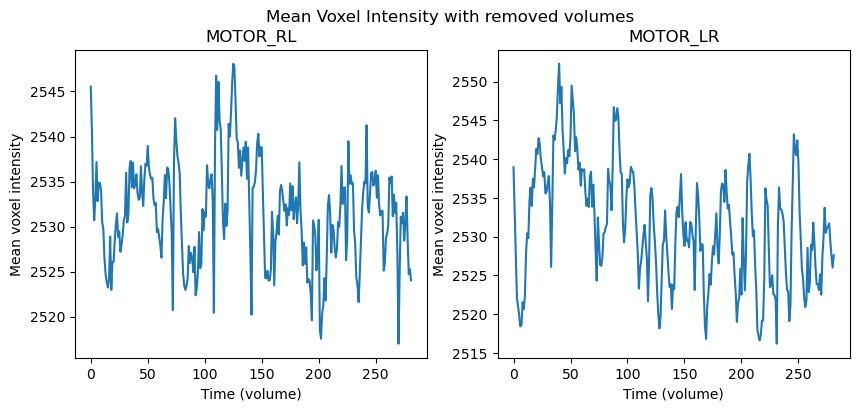

In [15]:
mean_LR_set = nib.load(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motorLR_bold_settled.nii.gz')).get_fdata().mean(axis=(0,1,2))
mean_RL_set = nib.load(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motorRL_bold_settled.nii.gz')).get_fdata().mean(axis=(0,1,2))


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Mean Voxel Intensity with removed volumes')

ax1.plot(mean_RL_set)
ax1.set_title('MOTOR_RL')
ax1.set(xlabel='Time (volume)', ylabel='Mean voxel intensity')

ax2.plot(mean_LR_set)
ax2.set_title('MOTOR_LR')
ax2.set(xlabel='Time (volume)', ylabel='Mean voxel intensity')

ATTENTION: LE FICHIER SETTLED EST DANS LE PREPROC ROOT

Before merging both runs together, we want to rescale them. The reason is that different runs can have different overall signal intensities or variances, because of: scanner gain or baseline drift, physiological noise changes or small differences in acquisition or head position.

In [16]:
import os
import numpy as np
import nibabel as nib
from nilearn.image import concat_imgs, new_img_like
import matplotlib.pyplot as plt

# Raw fMRI runs
runs_info = [
    ('sub-101410_task-motorLR', 'sub-101410_task-motorLR_bold_settled.nii.gz'),
    ('sub-101410_task-motorRL', 'sub-101410_task-motorRL_bold_settled.nii.gz')
]

##### Pourquoi mettre un run name?

# Output folder for preprocessed/scaled runs
output_dir = os.path.join(preproc_root, 'sub-101410', 'func')
os.makedirs(output_dir, exist_ok=True)

concatenated = [] #merged file

# Process each run independently
for run_name, run_file in runs_info:
    run_path = os.path.join(preproc_root, 'sub-101410', 'func', run_file)  
    img = nib.load(run_path)
    data = img.get_fdata(dtype=np.float32)  # Use float32 to save memory
    
    # Simple brain mask
    brain_mask = data > 0    
    global_var = np.var(data[brain_mask], dtype=np.float64)
    
    # Rescale to unit variance
    scaled_data = data / np.sqrt(global_var)
    del data #free memory
    
    # Merge scaled run
    new_img = new_img_like(img, scaled_data)
    concatenated.append(new_img)# merging both runs
    del scaled_data #free memory


concat_img = concat_imgs(concatenated)
concat_img.to_filename(os.path.join(output_dir, 'sub-101410_task-motor_concat.nii.gz'))



In [17]:
concat_path = os.path.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat.nii.gz')
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concat_path)

Text(0, 0.5, 'Mean voxel intensity')

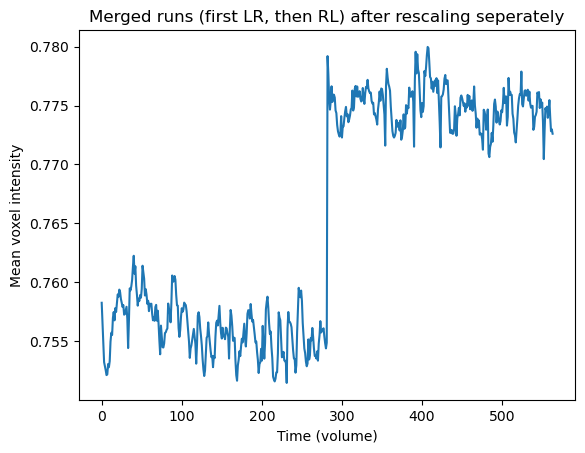

In [5]:
import matplotlib.pyplot as plt
import nibabel as nib
import os.path as op

mean_concat = nib.load(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat.nii.gz')).get_fdata().mean(axis=(0,1,2))

plt.plot(mean_concat)
plt.title('Merged runs (first LR, then RL) after rescaling seperately')
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In the mean voxel intensity plot above we can distinctly separate between the two runs (LR and RL). The jump betweeen them is roughly 0.03
#### WHY ????

## Motion correction

Attention: By default, MCFLIRT selects the middle volume of the EPI serie as reference to which other volumes are realigned.

In [6]:
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat')
path_moco_data = os.path.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [282] to 8 mm pixels
Registering volumes ... [283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][40

refnum = 282
Original_refvol = -1


Registering volumes ... [283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][

{}

In [7]:
path_original_data = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat')
path_moco_data = os.path.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco')
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)


(ipykernel_launcher.py:450): Gdk-WARNING **: 10:32:02.778: gdkdrawable-x11.c:952 drawable is not a pixmap or window


By observing the translation plot, we can clearly see the big jump from run LR to run RL. This shows us, that the reference image chosen by MCFLIRT must be part of the first run (LR).

#### Framewise Displacement

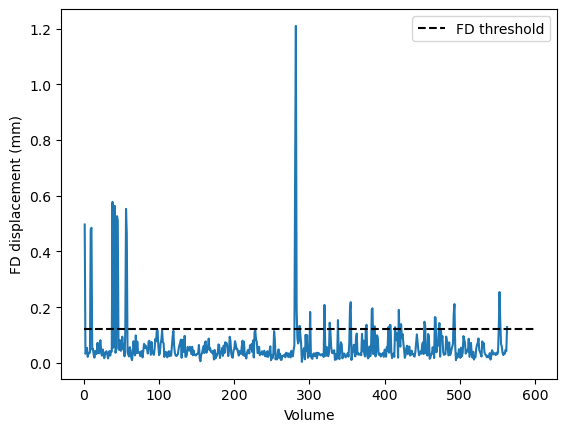

In [8]:
import matplotlib.pyplot as plt
import nibabel as nib
import os.path as op

def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco.par'))

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 600,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [9]:
print(f"Indices of frames above threshold: {(np.where(fd > threshold)[0] + 1).tolist()}")

Indices of frames above threshold: [1, 9, 10, 38, 41, 44, 45, 56, 57, 281, 282, 283, 287, 301, 320, 327, 338, 354, 355, 376, 383, 384, 386, 387, 405, 407, 408, 414, 419, 422, 453, 454, 467, 468, 473, 492, 493, 552, 553, 554, 563]


## Gaussian smoothing

I am unsure on how to determine the size of our filter. Currently it is 6 mm

In [10]:
import subprocess
output_path = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco')

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_moco', '-s', '2.547987090198743', '/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_moco_smoothed-6mm'], returncode=0)

In [11]:
smoothed_path = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco_smoothed-6mm')
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path)
fsleyesDisplay.load(smoothed_path)

# 3. GLM Design Matrix

In [8]:
import pandas as pd
import numpy as np
import os.path as op

# Load event files
LRevents = pd.read_csv(op.join(bids_root, 'sub-101410', 'func', 'sub-101410_task-motorLR_events.tsv'), sep=",")
RLevents = pd.read_csv(op.join(bids_root, 'sub-101410', 'func', 'sub-101410_task-motorRL_events.tsv'), sep=",")

TR = 0.72
n_removed = 2
time_removed = TR * n_removed  # 1.44 s

def trim_first_volumes(events, time_removed):
    """Shorten the first event and shift everything so that onset >= 0."""
    events = events.copy()
    # 1️⃣ Shorten the first event by the removed time
    events.loc[0, 'duration'] = events.loc[0, 'duration'] - time_removed
    
    # 2️⃣ Shift *only* later events earlier by time_removed
    events.loc[1:, 'onset'] = events.loc[1:, 'onset'] - time_removed
    
    # 3️⃣ Keep the first onset exactly at 0
    events.loc[0, 'onset'] = 0.0
    return events

LRevents = trim_first_volumes(LRevents, time_removed)
RLevents = trim_first_volumes(RLevents, time_removed)

# 4️⃣ Concatenate with onset offset for the second run
offset_time = (LRevents['onset'] + LRevents['duration']).max()
RLevents['onset'] = RLevents['onset'] + offset_time
events_concat = pd.concat([LRevents, RLevents], ignore_index=True)

In [9]:
# Rename the colomn
events_concat = events_concat.rename(columns={'condition': 'trial_type'})
events_concat

,onset,duration,trial_type
0,0.00,6.56,NaN
1,6.56,3.00,cue
2,9.56,12.00,rh
3,21.56,3.00,cue
4,24.56,12.00,lf
5,36.56,3.00,cue
6,39.56,12.00,t
7,51.56,3.00,cue
8,54.56,12.00,rf
9,66.56,3.00,cue


In [10]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
import os.path as op

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=0.72,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm', 
                           drift_model='polynomial',# adding drift model directly 
                           drift_order=3,
                          )

In [ ]:
# determining the number of scanns per run (the same for both runs)
n_scan_run = nib.load(op.join(preproc_root, 'sub-101410','func', 'sub-101410_task-motorRL_bold_settled.nii.gz')).shape[3]
run1_reg = np.zeros(2 * n_scan_run)
run2_reg = np.zeros(2 * n_scan_run)
run1_reg[:n_scan_run] = 1
run2_reg[n_scan_run:] = 1

reg_names = ['run1_LR_baseline', 'run2_RL_baseline']
extra_regs = [run1_reg, run2_reg]


import pandas as pd
confounds = pd.DataFrame(np.column_stack([run1_reg, run2_reg]),
                         columns=['run1_LR_baseline', 'run2_RL_baseline'])

fmri_concat_path = op.join(preproc_root, 'sub-101410','func', 'sub-101410_task-motor_concat.nii.gz')

# Fit the model to our design and data after adding 2 further regressors
fmri_glm = fmri_glm.fit(fmri_concat_path, events_concat, confounds)

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


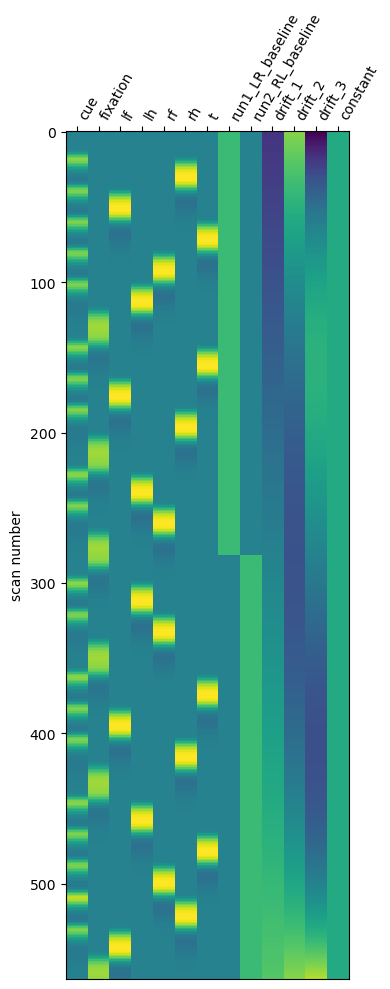

In [44]:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [45]:
# Create the dictionary of the conditions

conditions = {
    'cue': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 
    'fixation':np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'left_feet': np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'left_hand': np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'right_feet': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    'right_hand': np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
    'tongue': np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    
}

hand_minus_feet = conditions['left_hand'] + conditions['right_hand'] - conditions['left_feet'] - conditions['right_feet']


In [46]:
import nibabel as nib

z_map_hand_vs_feet = fmri_glm.compute_contrast(hand_minus_feet, output_type='z_score')

nib.save(z_map_hand_vs_feet, 'z_map_handVSfeet_uncorrected.nii.gz')

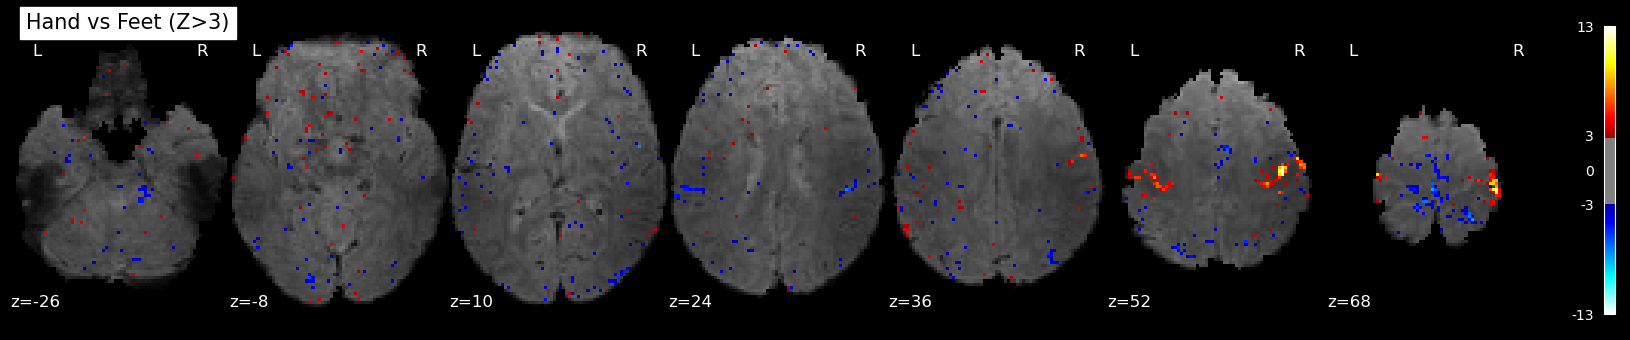

In [47]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import find_cut_slices

coords = find_cut_slices(z_map_hand_vs_feet)

mean_img_ = mean_img(fmri_concat_path),
plot_stat_map(z_map_hand_vs_feet, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=coords, black_bg=True,
              title='Hand vs Feet (Z>3)')
plt.show()

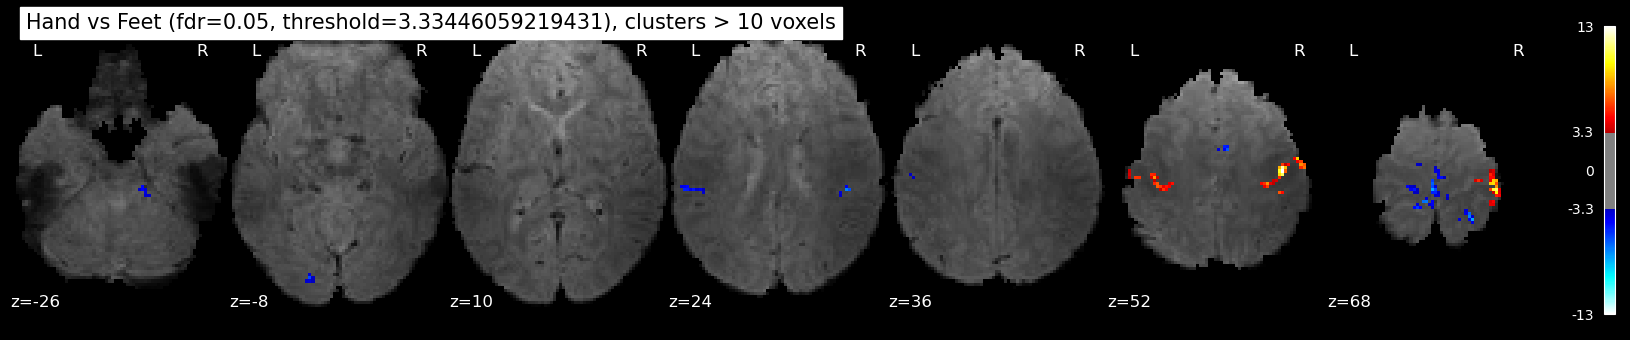

In [49]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map_hand_vs_feet, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=coords, black_bg=True,
              title='Hand vs Feet (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()

#### AAL atlas parcellation

In [50]:
from nilearn import datasets, image

# Downlod the AAL atlas
aal = datasets.fetch_atlas_aal()
aal_img = image.load_img(aal['maps'])
aal_labels = aal['labels']
aal_data = aal_img.get_fdata()

##### Superimposing the contrast map onto the atlas

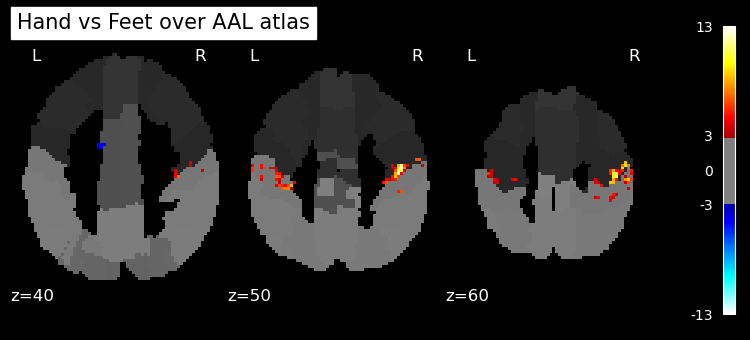

In [51]:
plot_stat_map(
    clean_map,
    bg_img=aal_img,
    threshold=3.0,
    display_mode='z',
    cut_coords=[40, 50, 60, 70],
    black_bg=True,
    title='Hand vs Feet over AAL atlas'
)
plt.show()



##### Find the name of the region with maximal contrast

In [52]:
from nilearn import datasets, image
import numpy as np

z_img = image.load_img(clean_map)
z_data = z_img.get_fdata()

# Find voxel with maximal contrast
max_idx = np.unravel_index(np.argmax(z_data), z_data.shape)
z_max = z_data[max_idx]
print("Z-max voxel:", max_idx)
print("Z max =", z_max)

# Identify the corresponding AAL region
region_id = str(int(aal_data[max_idx]))  ### ATTENTION, it has to be an int in a string

# Get the name of the AAL region
region_name = aal.labels[aal.indices.index(region_id)]
print(region_name)


Z-max voxel: (25, 51, 67)
Z max = 12.573736594747166
Precentral_R


# ICA

### ICA on the subject fMRI runs

In [14]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motorLR_bold_settled.nii.gz
|--------------- sub-101410_task-motorRL_bold_settled.nii.gz
|--------------- sub-101410_task-motor_concat.nii.gz
|--------------- sub-101410_task-motor_concat_moco.nii.gz
|--------------- sub-101410_task-motor_concat_moco.par
|--------------- sub-101410_task-motor_concat_moco_smoothed-6mm.nii.gz
|--------------- sub-101410_task-motor_concat_moco.mat/
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1

In [8]:
# Check the shape of fmri_data and the mask
print("FMRI data shape (full):", fmri_data.shape)
print("Mask shape:", mask_img.shape)
print("Number of voxels in the mask:", np.sum(mask_data > 0))  # Number of non-zero voxels in the mask

# Check the shape of the ICA components
print("ICA components shape:", ica_components.shape)

# For the first component, check the number of voxels it corresponds to
print("First ICA component size:", ica_components[0, :].shape)


FMRI data shape (full): (91, 109, 91, 564)
Mask shape: (91, 109, 91)
Number of voxels in the mask: 232973
ICA components shape: (20, 232973)
First ICA component size: (232973,)


[MultiNiftiMasker.fit] Loading data from [Nifti1Image('/home/jovyan/data/NeuralSignalsANDSignalProcessing/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_moco_smoothed-6mm.nii.gz')].
[{self.__class__.__name__}.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
________________________________________________________________________________
[Memory] Calling sklearn.utils.extmath.randomized_svd...
randomized_svd(array([[ 0.000792, ...,  0.001807],
       ...,
       [ 0.002578, ..., -0.00172 ]], dtype=float32), n_components=20, transpose=True, random_state=None, n_iter=3)
___________________________________________________randomized_svd - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004608, ...,  0.000823],
       ...,
       [-0.000889, ...,  0.002578]]), whiten='

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   10.7s


__________________________________________________________fastica - 9.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004608, ...,  0.000823],
       ...,
       [-0.000889, ...,  0.002578]]), whiten='arbitrary-variance', fun='cube', random_state=1786584300)
_________________________________________________________fastica - 14.3s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004608, ...,  0.000823],
       ...,
       [-0.000889, ...,  0.002578]]), whiten='arbitrary-variance', fun='cube', random_state=2024809280)
_________________________________________________________fastica - 10.3s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 

[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   45.4s


_________________________________________________________fastica - 10.4s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004608, ...,  0.000823],
       ...,
       [-0.000889, ...,  0.002578]]), whiten='arbitrary-variance', fun='cube', random_state=623560738)
_________________________________________________________fastica - 13.3s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004608, ...,  0.000823],
       ...,
       [-0.000889, ...,  0.002578]]), whiten='arbitrary-variance', fun='cube', random_state=639838547)
__________________________________________________________fastica - 8.3s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.

[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  1.3min


__________________________________________________________fastica - 9.6s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004608, ...,  0.000823],
       ...,
       [-0.000889, ...,  0.002578]]), whiten='arbitrary-variance', fun='cube', random_state=951456890)
_________________________________________________________fastica - 12.4s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.004608, ...,  0.000823],
       ...,
       [-0.000889, ...,  0.002578]]), whiten='arbitrary-variance', fun='cube', random_state=1941269937)
__________________________________________________________fastica - 9.9s, 0.2min
ICA component shape: (20, 232973)
Mask shape: (91, 109, 91)
Number of voxels in the mask: 232973


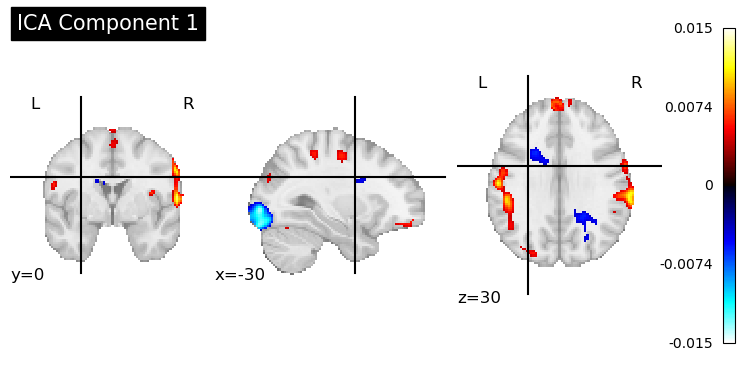

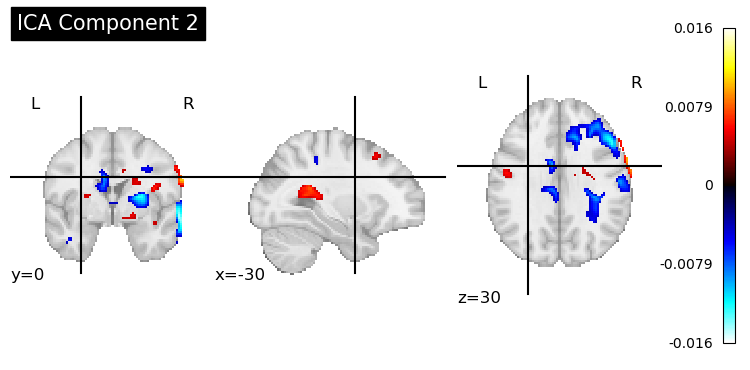

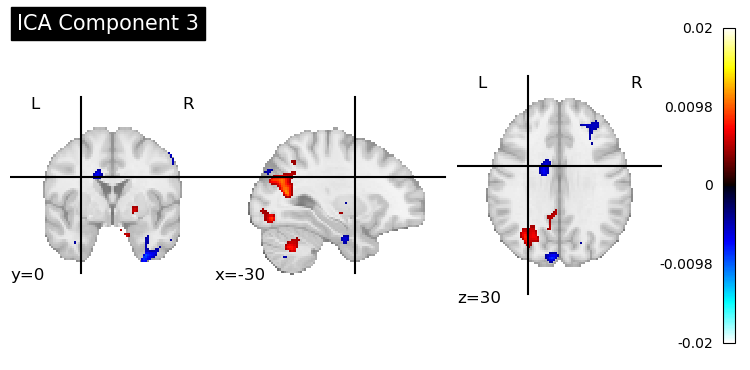

In [5]:
from nilearn.decomposition import CanICA
from nilearn import image, plotting
import numpy as np
import os.path as op

# Path to fMRI data
path_to_smoothed_image = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_moco_smoothed-6mm.nii.gz')
fmri_data = image.load_img(path_to_smoothed_image)

# Initialize CanICA (ICA from Nilearn)
n_components = 20  # You can adjust this
canica = CanICA(n_components=n_components, memory='nilearn_cache', memory_level=2, verbose=10)

# Fit the model
canica.fit(fmri_data)

# Extract the components (spatial maps)
ica_components = canica.components_

# Get the brain mask used during ICA fitting
mask_img = canica.mask_img_

# Apply the mask to get the mask shape
mask_data = mask_img.get_fdata()
n_voxels_in_mask = np.sum(mask_data > 0)  # Count of non-zero voxels in the mask

# Check the number of voxels in the components and mask
print(f"ICA component shape: {ica_components.shape}")  # Should be (n_components, n_voxels_in_mask)
print(f"Mask shape: {mask_img.shape}")
print(f"Number of voxels in the mask: {n_voxels_in_mask}")

# Visualize the first 3 ICA components
for i in range(min(n_components, 3)):
    # Create an empty 3D array to hold the reshaped component
    component_img_data = np.zeros(mask_img.shape)
    
    # Get the indices of the non-zero voxels in the mask
    mask_indices = np.where(mask_data > 0)
    
    # Fill the component_img_data with the ICA component values at the mask locations
    component_img_data[mask_indices] = ica_components[i, :]
    
    # Create a new image from the reshaped component
    component_img = image.new_img_like(fmri_data, component_img_data, affine=fmri_data.affine)
    
    # Plotting the component in ortho view
    plotting.plot_stat_map(component_img, title=f'ICA Component {i+1}', display_mode='ortho', draw_cross=True, cut_coords=[-30, 0, 30])
    plotting.show()


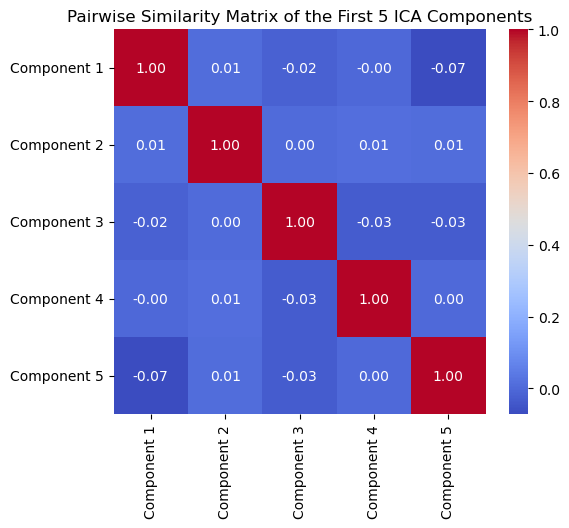

In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Select the first 5 ICA components
selected_components = ica_components[:5, :]

n_components = selected_components.shape[0]
similarity_matrix = np.zeros((n_components, n_components))

# Compute pairwise correlation (Pearson correlation) for each pair of components
for i in range(n_components):
    for j in range(i, n_components):  # Only need to compute upper triangle (symmetry)
        correlation = np.corrcoef(selected_components[i, :], selected_components[j, :])[0, 1]
        similarity_matrix[i, j] = similarity_matrix[j, i] = correlation

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=[f'Component {i+1}' for i in range(5)], 
                             index=[f'Component {i+1}' for i in range(5)])

# Plot the similarity matrix
plt.figure(figsize=(6, 5))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm", cbar=True, fmt='.2f')
plt.title('Pairwise Similarity Matrix of the First 5 ICA Components')
plt.show()
